# 3.3 미래에 볼 영화의 평점 예측하기

이번에는 평점 예측 기법을 알아보자.


## Step 1 탐색: MovieLens 데이터 살펴보기

MovieLens 데이터는 총 3개의 데이터셋으로 분리되어 있고 구성하는 피처는 아래와 같다.
* rating 데이터
    * user_id(유저 번호)
    * movie_id(영화 번호)
    * rating(점수)
    * time(데이터 등록 시간)
* movie 데이터
    * movie_id(영화 번호)
    * title(영화 제목)
    * genre(장르)
* user 데이터
    * user_id(유저 번호)
    * gender(성별)
    * age(나이)
    * occupation(직업-개인정보1)
    * zipcode(주소 코드-개인정보2)

In [1]:
import time, operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rating_file_path = "data/ml-1m/ratings.dat" # 위 파일은 '::' 구분자로 열을 구분함 -> delimiter='::' 필수
movie_file_path = "data/ml-1m/movies.dat"
user_file_path = "data/ml-1m/users.dat"

# 파일 경로, 열 이름 지정, 구분자, 인코딩 방식 지정, csv 파일 파싱할 때 사용할 엔진 지정
rating_data = pd.io.parsers.read_csv(rating_file_path,
                                     names=['user_id', 'movie_id', 'rating', 'time'],
                                     delimiter='::', encoding = "ISO-8859-1", engine='python')
movie_data = pd.io.parsers.read_csv(movie_file_path,
                                    names=['movie_id', 'title', 'genre'],
                                    delimiter='::', encoding = "ISO-8859-1", engine='python')
user_data = pd.io.parsers.read_csv(user_file_path,
                                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'],
                                    delimiter='::', encoding = "ISO-8859-1", engine='python')

In [2]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Step 2 분석: 탐색적 데이터 분석하기

이번에는 탐색적 분석을 통해 영화 데이터를 살펴보자. 아래 코드는 영화의 개수와 연도별 탐색에 대한 출력 결과이다. 영화의 개수는 약 4,000개 정도이고 1990년대 영화가 가장 많은 것을 알 수 있다.

In [5]:
# 총 영화의 개수 출력
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 Top 10 연도를 출력
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1]) # year 열 추가
movie_data['year'].value_counts()[:10]

total number of movie in data : 3883


year
1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: count, dtype: int64

다음으로 영화 데이터에서 가장 많이 등장한 장르가 무엇인지 탐색해보자. movie_data 피처인 genre는 '드라마 | 코미디 | 액션'처럼 '|' 구분자를 포함하여 여러 장르를 포함하고 있다. 이는 split() 함수를 이용하여 genre 데이터를 분리해야 한다. 분리 후 그래프로 시각화해보면 Drama 장르가 가장 인기가 많은 것을 알 수 있다.

C:\Users\CHOYS\AppData\Local\Temp\ipykernel_18740\3162312614.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=unique_genre_dict, palette='husl', dodge=False, legend=False, alpha=0.8)


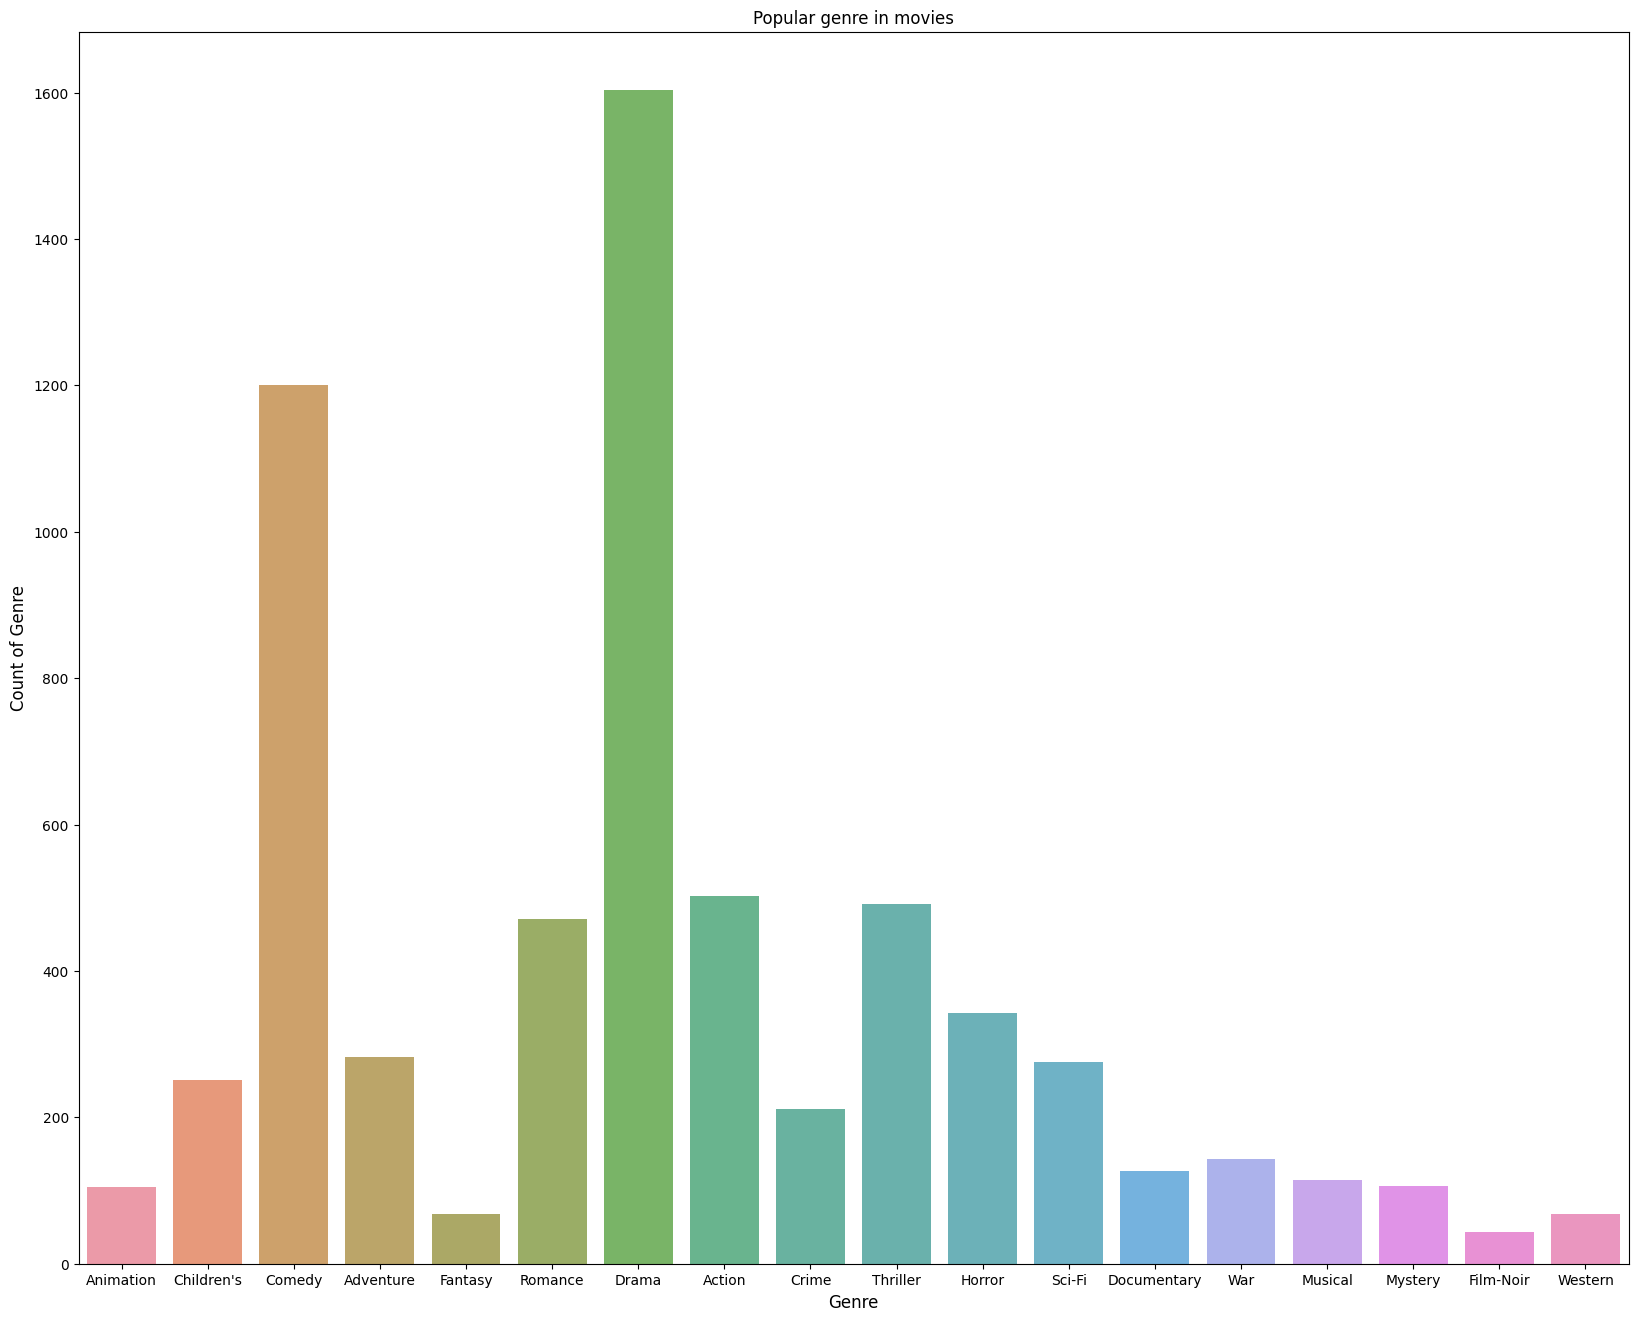

In [6]:
# 가장 많이 등장한 장르의 속성을 추출
unique_genre_dict = {}
for (index, row) in movie_data.iterrows():

    # genre 피처를 '|' 구분자로 분리
    genre_combination = row['genre']
    parsed_genre = genre_combination.split('|')
    #print(parsed_genre)

    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1

plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(data=unique_genre_dict, palette='husl', dodge=False, legend=False, alpha=0.8)
plt.title('Popular genre in movies')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count of Genre', fontsize=12)
plt.show()


분석 대상이 되는 유저의 수를 탐색해보면 총 6040명이다.

In [7]:
# 유저의 수를 탐색
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


지금까지 user_data, movie_data 데이터 특징은 '평점 예측'의 측면에서 중요한 탐색은 아니다. 하지만 rating 데이터는 평점 예측 데이터 분석에서 중요한 데이터이기 때문에 더 자세히 탐색할 필요가 있다.

아래의 코드는 각 영화가 얼마나 많은 평가를 받았는지 탐색한다.

결과를 보면 총 3883개의 영화 중 100개 미만의 평가를 받은 영화가 약 1700개나 되는 것을 알 수 있다.

**여기서 x축이 movie_id, y축이 count 맞나?**

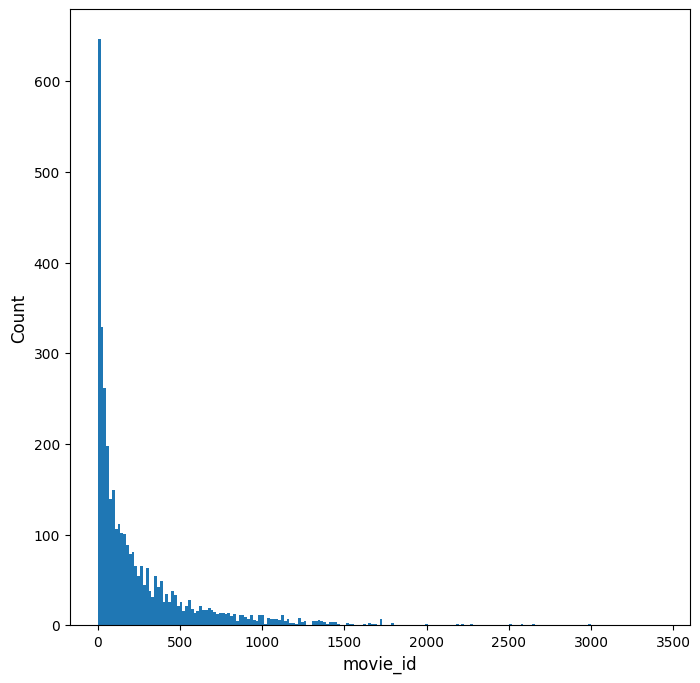

total number of movie in data : 3883
total number of movie rated below 100 : 1687


In [8]:
# 각 영화가 평가받은 횟수를 탐색한다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8,8]
fig = plt.hist(movie_rate_count, bins=200)
plt.xlabel("movie_id", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

다음으로 각 영화의 평균 평점을 알아보자.

In [9]:
# movie_grouped_rating_info = rating_data.groupby('movie_id')['rating'].mean().values
# fig = plt.hist(movie_grouped_rating_info, bins=150)

movie_grouped_rating_info = rating_data.groupby('movie_id')['rating'].agg(['count', 'mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']
movie_grouped_rating_info

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757
...,...,...
3948,862,3.635731
3949,304,4.115132
3950,54,3.666667


아래 그래프를 보면 영화 평점은 2점 ~ 4점 사이로 나타났으며, 이를 통해 대부분의 영화 평점은 2~4점 사이의 값으로 예측될 것이다라는 가설을 수립할 수 있다. (x축: 영화 평균 평점, y축: 개수)

<Axes: >

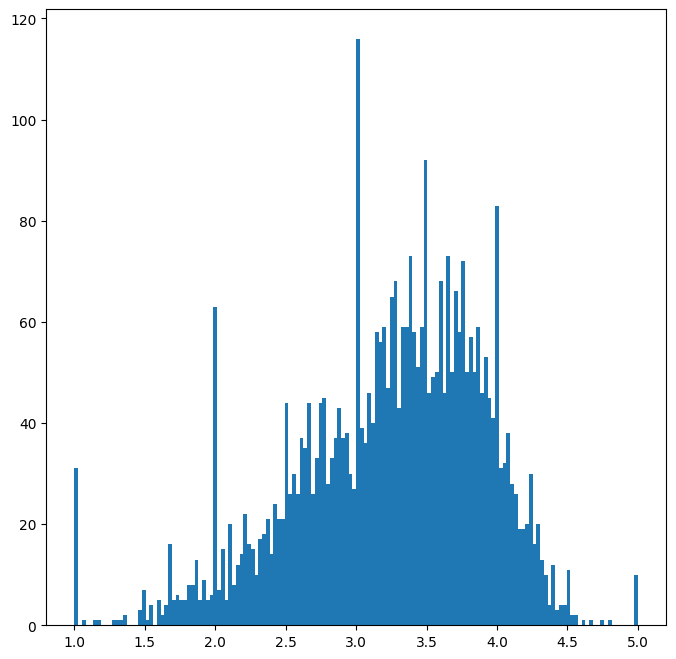

In [10]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

이제 영화 평점 예측을 수행해보자. 현재 분석 중인 MovieLens 데이터는 U-I-R(User-Item-Rating) 데이터셋이다. 이는 행렬로 나타내기에 용이하고, 아래와 같이 시각화할 수 있다.

In [11]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(['user_id', 'movie_id']).unstack()

In [12]:
rating_table

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
6036        NaN  NaN  NaN  2.0  NaN  3.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6037        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6038        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6039        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6040        3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...       ...  ...  ...  ...  ...  ...  ...  ...  
6036      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6037      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6038      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6039      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6040      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[6040 rows x 3706 columns]

아무것도 안보인다.. 원래대로라면 점이 무수하게 찍혀있을 것이다. 암튼 위의 rating_table을 보면 일부분만 채워진 희소 행렬이라는 것을 알 수 있다. 비어있는 Rating을 채워 넣을 수 있는 가장 대표적인 방법은 행렬의 빈 공간을 채우는 **행렬 완성** 기법이다.

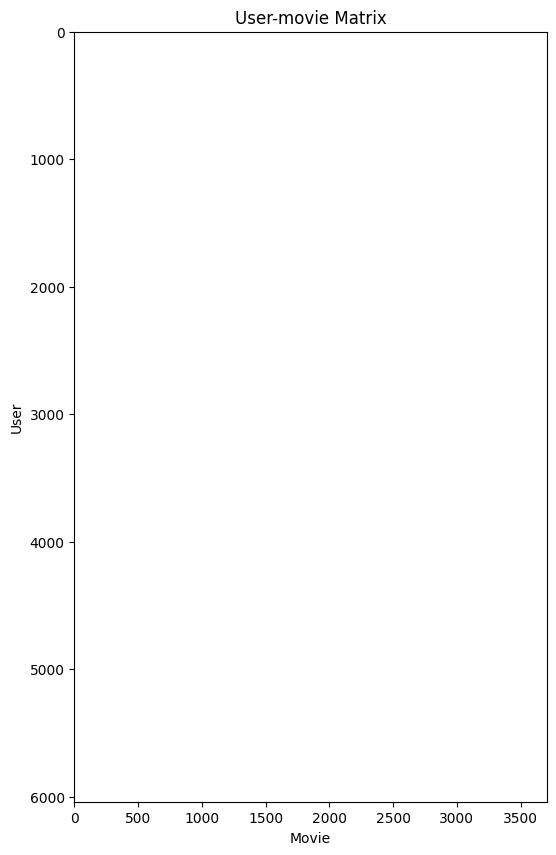

In [13]:
# user-movie 표를 시각화
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table, cmap='viridis')
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

## Step 3 예측: 수학적 기법을 활용해 평점 예측하기

행렬 완성은 **행렬 분해**를 이용한다. 행렬 분해는 수학적 성질을 이용하여 하나의 행렬을 여러 개의 행렬 곱으로 나타내는 방법이다.

본 예제에서는 행렬 분해 중에서도 가장 활용도가 높은 **특이값 분해**를 활용하여 영화 평점을 예측할 것이다.



먼저 평점 범위가 1~5인 Reader 객체를 생성한다. 그리고 load_from_df()와 build_full_trainset() 함수를 이용하여 rating 데이터를 surprise 라이브러리의 데이터셋 형태로 변환한다. 마지막으로 SVD 클래스를 언언한 뒤 model.fit() 함수로 행렬 완성 모델을 학습한다.

In [14]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" %(train_end - train_start))

training time of model: 6.49 seconds


다음으로 학습한 모델의 평점 예측 결과를 보기 위해 한 명의 데이터를 선정한다. 예제에서는 user_id가 4인 유저를 선정하였다.

In [17]:
# user_id가 4인 유저의 영화 평가 데이터
target_user_id = 4
target_user_data = rating_data[rating_data['user_id'] == target_user_id]
target_user_data.head()

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [19]:
# user_id가 4인 유저가 평가한 영화 히스토리 정보를 추출
target_user_movie_rating_dict = {} 

# 유저 4가 평가한 영화id:영화평점이 저장
for (index, row) in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']

print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


이제 예측 모델에 4번 유저의 정보를 입력하여 '아직 보지 않은 영화들의 평점'의 예측해보자. model.test()를 이용하는데 입력 데이터는 (target_user_id, movie_id, rating) 형태의 리스트여야 한다.

아래 결과는 유저 4번이 보지 않은 영화들의 평점을 예측한 딕셔너리이다.

In [23]:
# 타켓 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성
test_data = []
for (index, row) in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

# 타겟 유저의 평점 점수를 예측
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(target_user_predictions,
                                                            target_user_id,
                                                            target_user_movie_rating_dict)

target_user_movie_predict_dict

{1: 4.250254315442609,
 2: 3.0940839405565828,
 3: 2.7597496481074204,
 4: 3.289150547106352,
 5: 3.0427924498500682,
 6: 4.414006642424564,
 7: 3.4854530321659234,
 8: 3.26720187239007,
 9: 2.780622723500426,
 10: 3.2822196430703214,
 11: 3.9824706353838617,
 12: 2.0504234846569442,
 13: 3.9756344330696205,
 14: 4.324285427625727,
 15: 2.453839836240649,
 16: 4.103423103628547,
 17: 4.520304688864296,
 18: 2.6204991991922277,
 19: 2.03481805593053,
 20: 2.944121418125383,
 21: 4.080087767236553,
 22: 3.7069228443725506,
 23: 2.7763162047818275,
 24: 3.4343561070269337,
 25: 4.399021636477513,
 26: 3.9077498507725204,
 27: 2.810396136520113,
 28: 4.3689472855805285,
 29: 3.8626268034250053,
 30: 4.065063400117106,
 31: 3.3502254010505577,
 32: 3.6657596454795476,
 33: 3.0788585719699864,
 34: 4.464170963648084,
 35: 3.93270400902537,
 36: 4.481561276745386,
 37: 3.4408199493941973,
 38: 2.153718873195286,
 39: 4.2897874376441685,
 40: 3.974669776141478,
 41: 4.270075165094975,
 42: 3.1

In [25]:
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(),
                                     key=operator.itemgetter(1), reverse=True)[:10]
target_user_top10_predicted

[(106, 5),
 (213, 5),
 (326, 5),
 (602, 5),
 (608, 5),
 (615, 5),
 (670, 5),
 (750, 5),
 (858, 5),
 (898, 5)]

In [28]:
# Top 10 영화의 제목을 매칭하여 출력
movie_dict = {}
for (index, row) in movie_data.iterrows():
    movie_dict[row['movie_id']] = row['title']

for (id, rating) in target_user_top10_predicted:
    print(f"{movie_dict[id]} : {rating}")

Nobody Loves Me (Keiner liebt mich) (1994) : 5
Burnt By the Sun (Utomlyonnye solntsem) (1994) : 5
To Live (Huozhe) (1994) : 5
Great Day in Harlem, A (1994) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
World of Apu, The (Apur Sansar) (1959) : 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : 5
Godfather, The (1972) : 5
Philadelphia Story, The (1940) : 5


### Step 4 평가: 예측 모델 평가하기

과연 이 예측이 얼마나 정확할까? 이를 해소하기 위해서는 모델이 얼마나 정확하게 행렬을 완성했는지 평가해야한다. 행렬 완성의 가장 보편적인 평가 방법은 RMSE를 계산하는 것이다.

In [36]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를생성. 학습 데이터와 테스트 데이터를 8:2로 분리
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" %(train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력
print("RMSE of test dataset in SVD model:", accuracy.rmse(predictions))

training time of model: 18.82 seconds
RMSE: 0.8609
RMSE of test dataset in SVD model: 0.860868922821993


이번에는 4번 유저의 예측 평점과 실제 평점을 비교하는 시각화 그래프를 출력해보자. 아래의 코드는 4번 유저가 보고 평가한 영화를 아직 보지 않았다는 가정하에 영화의 가상 예측 평점을 계산한 것이다.

In [41]:
# 타켓 유저 정보를 테스트 데이터로 생성
test_data = []
for (index, row) in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

# 타겟 유저이 평점 점수를 예측
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for (uid, mid, rating, predicted_rating, _) in target_user_predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(target_user_predictions,
                                                            target_user_id,
                                                            target_user_movie_rating_dict)

target_user_movie_predict_dict

{260: 4.042583453566456,
 480: 3.2706120945804122,
 1036: 3.638795703346946,
 1097: 4.2084964557591595,
 1196: 3.7043353888012645,
 1198: 4.242328422448672,
 1201: 4.220937648973189,
 1210: 3.3562483439948982,
 1214: 4.292078558938379,
 1240: 3.971785248591141,
 1387: 4.281576804358598,
 1954: 3.8635315498938443,
 2028: 4.5284144832128455,
 2366: 3.9878681157126703,
 2692: 4.414475745987684,
 2947: 3.8510906250280343,
 2951: 4.031632333992667,
 3418: 4.333095416993286,
 3468: 4.765853817052799,
 3527: 3.1293062736243638,
 3702: 3.871995738460268}

4번 유저가 실제로 관람했던 21개 영화에 대한 가상 예측 평점, 실제 평점, 그리고 영화 제목을 출력해보자

In [44]:
movie_title_list = []
origin_rating_list = []
predicted_rating_list = []

idx = 0
for (movie_id, predicted_rating) in target_user_movie_predict_dict.items():
    idx += 1
    movie_title = movie_dict[movie_id]
    rating = target_user_movie_rating_dict[movie_id]
    print(f"movie {idx} : {movie_title} - {rating} / {predicted_rating:.2f}")

    movie_title_list.append(movie_title)
    origin_rating_list.append(rating)
    predicted_rating_list.append(predicted_rating)

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.04
movie 2 : Jurassic Park (1993) - 4 / 3.27
movie 3 : Die Hard (1988) - 4 / 3.64
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.21
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.70
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.24
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.22
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.36
movie 9 : Alien (1979) - 4 / 4.29
movie 10 : Terminator, The (1984) - 5 / 3.97
movie 11 : Jaws (1975) - 5 / 4.28
movie 12 : Rocky (1976) - 5 / 3.86
movie 13 : Saving Private Ryan (1998) - 5 / 4.53
movie 14 : King Kong (1933) - 4 / 3.99
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.41
movie 16 : Goldfinger (1964) - 5 / 3.85
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.03
movie 18 : Thelma & Louise (1991) - 4 / 4.33
movie 19 : Hustler, The (1961) - 5 / 4.77
movie 20 : Predator (1987) - 1 / 3.13
movie 21 : Mad Max (1979) - 4 / 3.87


각 영화의 실제 평점과 예측 평점을 시각화해보자.
얼추 비슷한 것 같다.

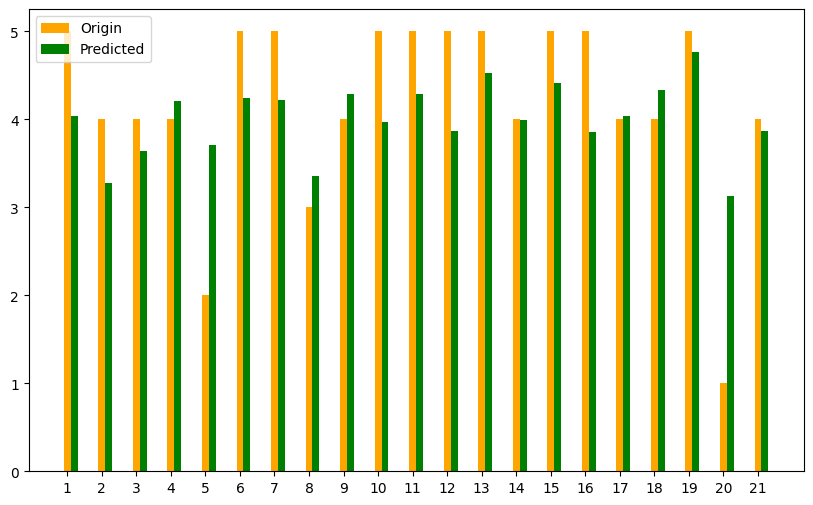

In [53]:
plt.rcParams['figure.figsize'] = [10, 6]
index = np.arange(1, len(movie_title_list) + 1)
bar_width = 0.2

plt.bar(index, origin_rating_list, bar_width, color="orange", label="Origin")
plt.bar(index+bar_width, predicted_rating_list, bar_width, color="green", label="Predicted")
plt.xticks(index)
plt.legend()
plt.show()

### 연습문제

1. Boston Housing 데이터셋으로 회귀 분석을 수행하기 위한 데이터셋을 분리
  2. 분리한 데이터셋으로 회귀 분석을 수행
  3. 학습 완료된 모델의 R2 score를 평가
  4. 회귀 모델 피처의 계수를 출력

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "data/BostonHousing2.csv"
housing = pd.read_csv(file_path)
housing = housing.rename(columns={'CMEDV':'y'})
housing.head()

,TOWN,LON,LAT,y,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,-70.955,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,-70.950,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,-70.936,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,-70.928,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,-70.922,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [58]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 훈련, 테스트 데이터셋을 생성
X = housing[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y = housing['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [59]:
# 모델을 학습
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [62]:
# R2 score를 출력
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7490284664199387
0.7009342135321552


In [63]:
# 각 피처의 계수 출력
print(lr.coef_)

[-1.11193551e-01  5.09415195e-02  3.25436161e-02  3.02115825e+00
 -1.54108556e+01  4.04590890e+00 -1.97595267e-03 -1.56114408e+00
  3.27038718e-01 -1.38825230e-02 -8.22151628e-01  8.74659468e-03
 -5.85060261e-01]


### 미니 퀴즈 3-3 (영화의 연대별 개수를 탐색해 보자.)

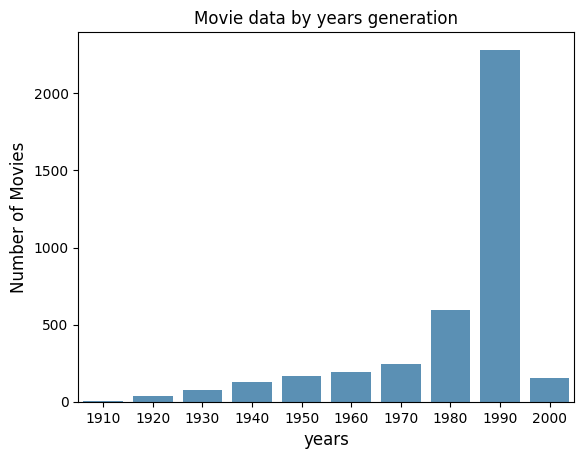

In [38]:
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+'0') # ex) 1980, 1990, 2000 년대
movie_year_term = movie_data['year_term'].value_counts().sort_index() # 인덱스 정렬

sns.barplot(movie_year_term, alpha=0.8)
plt.title('Movie data by years generation')
plt.xlabel('years', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.show()

### 미니퀴즈 3-4 (유저의 성별 탐색, 유저의 연령대 탐색)

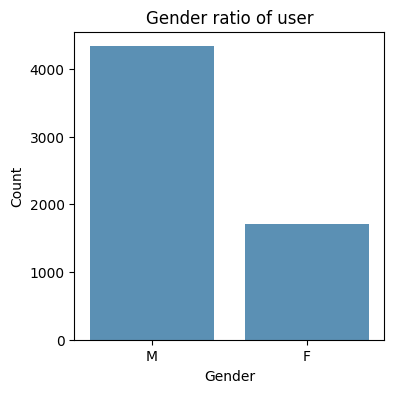

In [132]:
# 유저의 성별 탐색
plt.rcParams['figure.figsize'] = [4,4]
gender_count = user_data['gender'].value_counts()
sns.barplot(gender_count, alpha=0.8) #혹은 plt.bar(gender_count.index, gender_count.values)
plt.title("Gender ratio of user")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

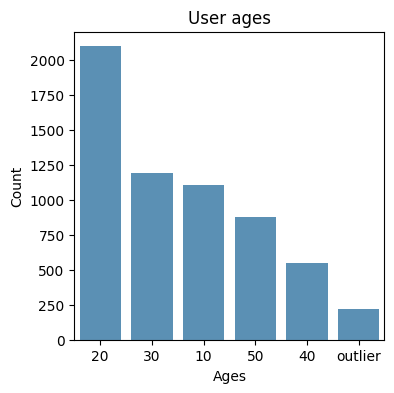

In [139]:
# 유저의 연령대 탐색
user_data['age_term'] = user_data['age'].apply(lambda x: str(x)[0]+'0' if len(str(x)) >= 2 else 'outlier')  
user_age_term = user_data['age_term'].value_counts()

sns.barplot(user_age_term, alpha=0.8)
plt.title("User ages")
plt.xlabel("Ages")
plt.ylabel("Count")
plt.show()

### 미니 퀴즈 3-5 (유저별로 평가한 영화 개수, 평균 영화 점수, 영화 점수의 편차)

아래 그래프는 유저별로 평가한 영화 개수(x축: 영화 개수, y축: 유저 개수)

대부분의 유저가 500개 이하의 영화를 평가한 것을 알 수 있다.

<Axes: >

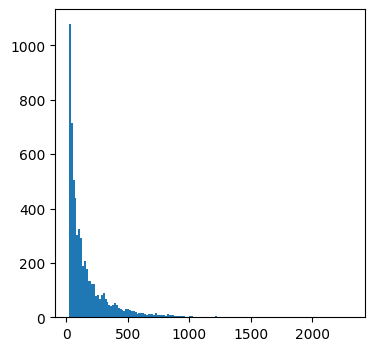

In [145]:
# 유저별로 평가한 영화 개수
user_rating_count = rating_data.groupby('user_id')['movie_id'].count()
user_rating_count.hist(bins=150, grid=False)

아래 그래프는 유저별로 평가한 평균 영화 점수를 시각화한 그래프이다. (x축: 유저들이 평가한 평균 평점, y축: 유저 개수)

대부분의 유저가 3~4 점을 준 것을 알 수 있다.

<Axes: >

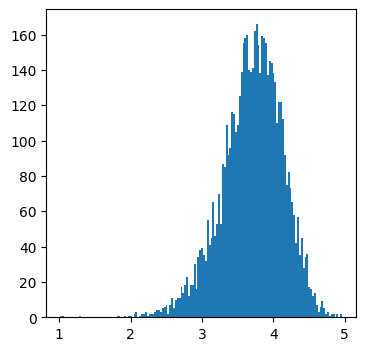

In [152]:
# 유저별로 평가한 평균 영화 점수
user_rating_mean = rating_data.groupby('user_id')['rating'].mean()
user_rating_mean.hist(bins=150, grid=False)

아래 그래프는 유저별로 평가한 영화 점수의 편차를 시각화한 그래프이다(x축: 편차, y축: 유저 개수)

1에 가까운 것을 보면 대부분의 유저들은 영화를 평가할 때 영화 평균 점수와 비슷한 점수를 주었다는 것을 알 수 있다.

<Axes: >

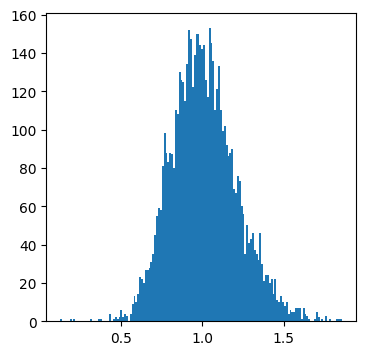

In [153]:
# 유저별로 평가한 영화 점수의 편차
user_rating_std = rating_data.groupby('user_id')['rating'].std()
user_rating_std.hist(bins=150, grid=False)

### 미니퀴즈 3-6

SVD에는 n_factor와 같은 파라미터들이 존재한다. 사용자가 설정하는 이러한 파라미터를 **하이퍼 파라미터**라고 한다. 위의 예제에서 하이퍼 파라미터를 바꿔가며 RMSE를 출력해보자

* RMSE를 이용한 적당한 하이퍼 파라미터 n_factors를 찾아보자.
* 하이퍼 파라미터 n_factors 설정 변화에 따른 RMSE 그래프를 출력해보자.

In [34]:
import time

rmse_list_by_factors = []
time_list_by_factors = []

for n in range(1,15):
    train_start = time.time()
    model = SVD(n_factors=n,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
    model.fit(train_data)
    train_end = time.time()
    print("training time of model: %.2f seconds" %(train_end - train_start))
    time_list_by_factors.append(train_end - train_start)
    
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)

training time of model: 17.75 seconds
RMSE: 0.8856
training time of model: 17.80 seconds
RMSE: 0.8794
training time of model: 17.94 seconds
RMSE: 0.8699
training time of model: 18.09 seconds
RMSE: 0.8670
training time of model: 18.22 seconds
RMSE: 0.8660
training time of model: 18.31 seconds
RMSE: 0.8625
training time of model: 18.42 seconds
RMSE: 0.8595
training time of model: 18.50 seconds
RMSE: 0.8623
training time of model: 18.62 seconds
RMSE: 0.8617
training time of model: 18.83 seconds
RMSE: 0.8639
training time of model: 18.93 seconds
RMSE: 0.8660
training time of model: 18.98 seconds
RMSE: 0.8677
training time of model: 19.15 seconds
RMSE: 0.8703
training time of model: 19.31 seconds
RMSE: 0.8714


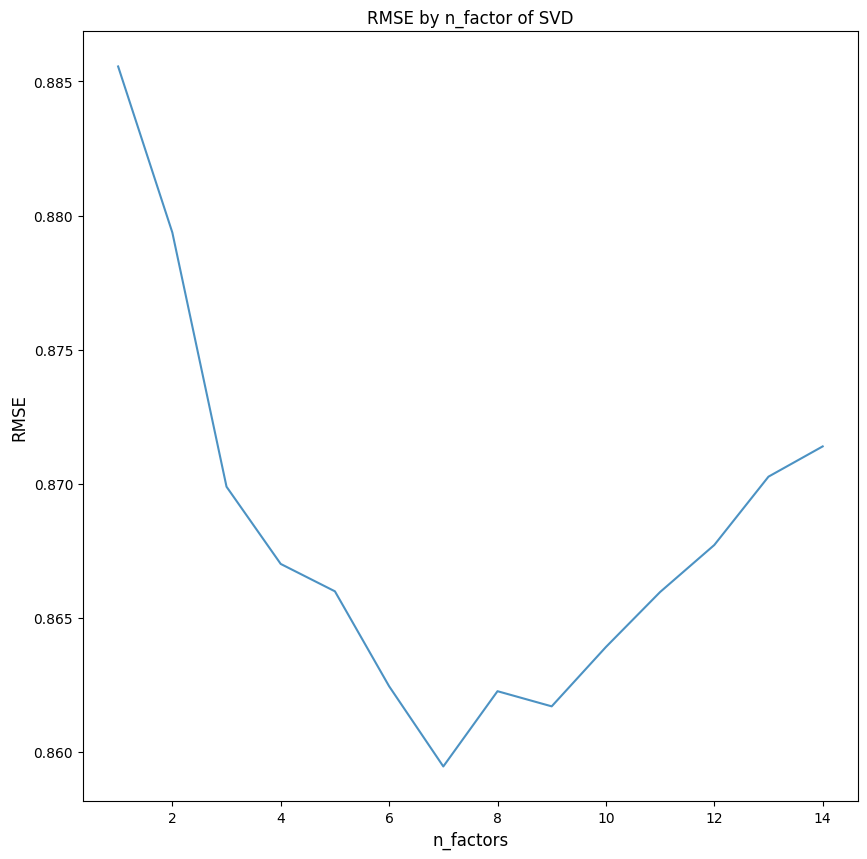

In [35]:
plt.plot(range(1,15), rmse_list_by_factors, alpha=0.8)
plt.title("RMSE by n_factor of SVD")
plt.xlabel("n_factors", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.show()

n_factors가 7일 때 가장 최적인 듯 하다.